<a href="https://colab.research.google.com/github/jihenBouguerra/ashrae-energy-prediction/blob/master/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data from kaggle 


*   Create kaggle folder 
*   Import API
*   Download data 
*   Unzip data 



In [0]:
!rm -dr ~/.kaggle
!pip install -U -q kaggle

!mkdir -p ~/.kaggle
from google.colab import files


rm: cannot remove '/root/.kaggle': No such file or directory


In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jihenbouguerra","key":"657701b0b6c05ca568ee44edbb73729e"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 85.1MB/s]
 98% 163M/167M [00:02<00:00, 54.6MB/s]
100% 167M/167M [00:02<00:00, 69.4MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 182MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 39.3MB/s]
 92% 81.0M/88.4M [00:00<00:00, 66.7MB/s]
100% 88.4M/88.4M [00:00<00:00, 138MB/s] 
 90% 108M/120M [00:00<00:00, 164MB/s] 
100% 120M/120M [00:00<00:00, 176MB/s]


In [0]:
!unzip weather_train.csv.zip
!unzip weather_test.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
!unzip sample_submission.csv.zip

Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  test.csv.zip
  inflating: test.csv                 (warning) cannot set modif./access times
          No such file or directory
Archive:  train.csv.zip
  inflating: train.csv                (warning) cannot set modif./access times
          No such file or directory
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


# Lest's start !!!!!

*   Importing libraries 




In [0]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold,GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from plotly.offline import init_notebook_mode,iplot,plot
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

This method converts the feature type to reduce thr memory usage

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Reading the CSV files
 and keeping a copy   just in case (=P)

In [0]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_weather_train = pd.read_csv("data/weather_train.csv")
df_weather_test = pd.read_csv("data/weather_test.csv")
df_metadata=pd.read_csv("data/building_metadata.csv")

In [0]:
train = df_train.copy()
test= df_test.copy() 
weather_train=df_weather_train.copy()
weather_test =df_weather_test.copy()
metadata=df_metadata.copy()
gc.collect()

243


# Data visualisation


*   Check the distribution of data using the distplot and the boxplot



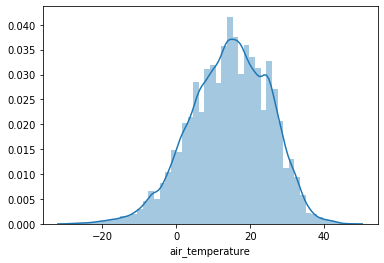

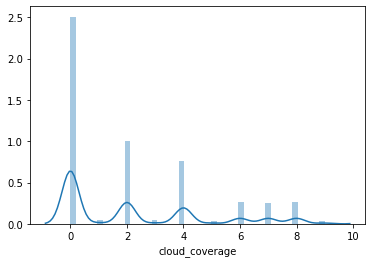

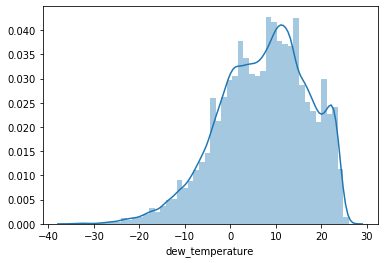

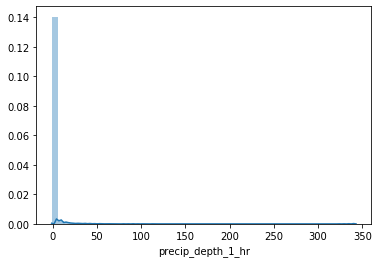

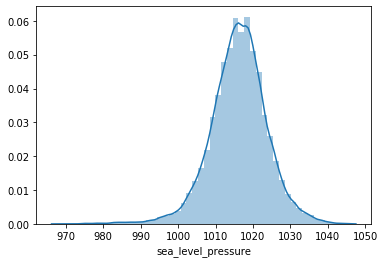

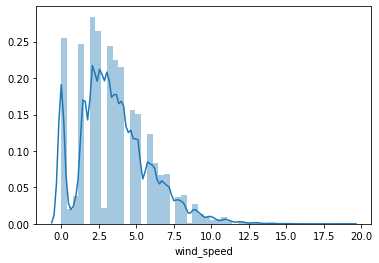

In [0]:
#Distribution of train feature
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.distplot(weather_train[col].dropna())

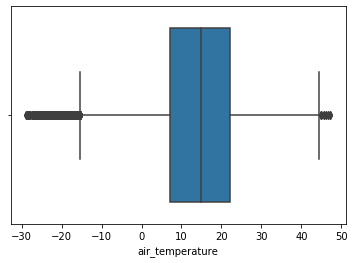

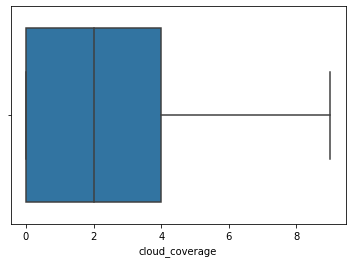

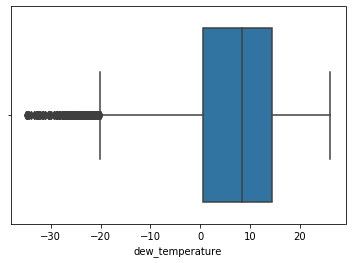

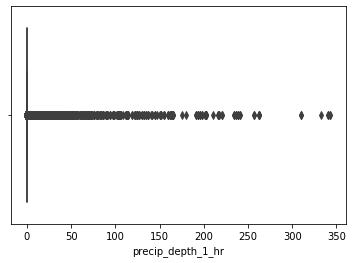

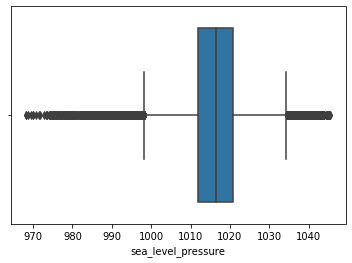

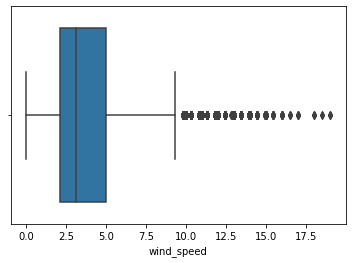

In [0]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.boxplot(weather_train[col].dropna())

# Conclusion

*   Distribution of sea_level_pressure looks like a normal distribution.
*   Lot of 0 values in precip_depth_1_hr variable.
*   Wind_Speed distribution looks like positively skewed.
*   Dew Temperature looks like a Negatively skewed distribution.
*   Cloud_Coverage takes distinct values unlike these other variables.

# Data cleaning + Preparation


*   Fill missing values 
*   Add new date feature
*   Reset index
*   Reset types
*   Merge Metadata building table + train table
*   Merge train table +  weather train table
*   Remove Rows with null values
*   Check the correlated values
*   Label encoder
*   Fill numeric values with the mean value 


## Fill missing values 
## Add new date feature 
## Reset index for Fast Update





In [0]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    return weather_df

In [0]:
weather_train = fill_weather_dataset(weather_train)
weather_train.columns
weather_test = fill_weather_dataset(weather_test)
weather_test.columns


Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

In [0]:
df= weather_train.copy()
df['air_temperature'] = df['air_temperature'].astype('float32')
df['cloud_coverage'] = df['cloud_coverage'].astype('float16')
df['dew_temperature'] = df['dew_temperature'].astype('float16')
df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
df['wind_direction'] = df['wind_direction'].astype('float32')
df['wind_speed'] = df['wind_speed'].astype('float16')
weather_train= df.copy()
df= weather_test.copy()
df['air_temperature'] = df['air_temperature'].astype('float32')
df['cloud_coverage'] = df['cloud_coverage'].astype('float16')
df['dew_temperature'] = df['dew_temperature'].astype('float16')
df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
df['wind_direction'] = df['wind_direction'].astype('float32')
df['wind_speed'] = df['wind_speed'].astype('float16')
weather_test= df.copy()

In [0]:
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
train = pd.merge(train,metadata,on='building_id',how='left')
test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 4)
Testing Data Shape (41697600, 4)
Training Data Shape (20216100, 9)
Testing Data Shape (41697600, 9)


0

# Merge Metadata building table + train table
# Merge Train table + Weather train table

In [0]:
train = pd.merge(train,weather_train,on=['site_id','timestamp'],how='left')
test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()


Training Data Shape (20216100, 16)
Testing Data Shape (41697600, 16)


0

In [0]:
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          # 'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          # 'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          # 'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

# Remove Rows with null values

In [0]:
idx_to_drop = list((train[(train['site_id'] == 0) & (train['timestamp'] < "2016-05-21 00:00:00")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

idx_to_drop = list(train[(train['meter'] == "Electricity") & (train['meter_reading'] == 0)].index)
print(len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)
idx_to_drop = list((train[(train['building_id']==1099)&(train['meter_reading'] > 30000)&(train['meter'] == "Steam")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

392857


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



0
0


In [0]:
train['meter_reading'] = np.log1p(train['meter_reading'])


# Label encoder

In [0]:

le = LabelEncoder()

train['meter']= le.fit_transform(train['meter']).astype("uint8")
test['meter']= le.fit_transform(test['meter']).astype("uint8")
train['primary_use']= le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use']= le.fit_transform(test['primary_use']).astype("uint8")

# Check the correlated values

In [0]:
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
building_id,NaN,0.209164,0.076379,0.980292,0.068045,0.084392,0.206786,0.348353,0.313025,0.143564,0.096365,0.088082,0.089607,0.046686,0.008138
meter,NaN,NaN,0.041417,0.242600,0.079594,0.132254,0.017342,0.176926,0.007746,0.134420,0.075971,0.018892,0.039250,0.025739,0.080740
meter_reading,NaN,NaN,NaN,0.096360,0.055871,0.376335,0.197650,0.342052,0.004755,0.014194,0.023413,0.013098,0.011381,0.016991,0.029325
site_id,NaN,NaN,NaN,NaN,0.086547,0.088052,0.175358,0.336626,0.305147,0.109223,0.123464,0.086733,0.070980,0.049433,0.015841
primary_use,NaN,NaN,NaN,NaN,NaN,0.090409,0.052822,0.213936,0.045337,0.131355,0.015790,0.019882,0.037005,0.025193,0.052997
square_feet,NaN,NaN,NaN,NaN,NaN,NaN,0.147862,0.584495,0.014549,0.038775,0.021906,0.036118,0.012909,0.017812,0.035241
year_built,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.147381,0.167201,0.077240,0.095199,0.021107,0.028277,0.063277,0.049114
floor_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184021,0.214326,0.174789,0.140502,0.003962,0.074262,0.020472
air_temperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001965,0.750891,0.004255,0.304421,0.106697,0.086288
cloud_coverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072797,0.045830,0.110430,0.013562,0.176253


In [0]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)
#test_row_id= test["row_id"]
#test.drop("row_id",axis=1,inplace=True)

There are 1 columns to remove.
Following columns can be dropped ['site_id']


In [0]:
print (train.isnull().sum())

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16316310
air_temperature          90495
cloud_coverage           90495
dew_temperature          90495
precip_depth_1_hr        90495
sea_level_pressure       90495
wind_direction           90495
wind_speed               90495
dtype: int64


#  Fill numeric values with the mean value 

In [0]:
train['air_temperature'].fillna(train['air_temperature'].mean(), inplace=True)
train['dew_temperature'].fillna(train['dew_temperature'].mean(), inplace=True)
train['wind_speed'].fillna(train['wind_speed'].mean(), inplace=True)
train['precip_depth_1_hr'].fillna(method='bfill', inplace=True)
train['wind_direction'].fillna(method='ffill', inplace=True)
train['sea_level_pressure'].fillna(method='ffill', inplace=True)
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.weekday
train['hour'] = train['timestamp'].dt.hour
train['weekend'] = np.where((train['day'] == 5) | (train['day'] == 6), 1, 0)

gc.collect()
print (train.isnull().sum())

train.dtypes


building_id                  0
meter                        0
timestamp                    0
meter_reading                0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16316310
air_temperature              0
cloud_coverage           90495
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
month                        0
day                          0
hour                         0
weekend                      0
dtype: int64


building_id                    int16
meter                          uint8
timestamp             datetime64[ns]
meter_reading                float64
primary_use                    uint8
square_feet                    int32
year_built                   float16
floor_count                  float16
air_temperature              float32
cloud_coverage               float16
dew_temperature              float32
precip_depth_1_hr            float32
sea_level_pressure           float32
wind_direction               float32
wind_speed                   float32
month                          int64
day                            int64
hour                           int64
weekend                        int64
dtype: object

In [0]:
y = train['meter_reading']
train.drop(['meter_reading','floor_count'],axis=1,inplace=True)


In [0]:
train.columns


Index(['building_id', 'meter', 'timestamp', 'primary_use', 'square_feet',
       'year_built', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'day', 'hour', 'weekend'],
      dtype='object')

In [0]:
print(train.shape, df_train.shape)
print(test.shape, df_test.shape)
print( y.shape)
submission=pd.read_csv("data/sample_submission.csv")

(19823243, 17) (20216100, 4)
(41697600, 15) (41697600, 4)
(19823243,)


In [0]:
print(submission.shape)


(41697600, 2)


In [0]:
print(test.columns)

print(train.columns)


categoricals = ["building_id","primary_use", "meter", "month", "day", "hour", "weekend"]



numericals = ["square_feet", "air_temperature", "dew_temperature",
              "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]

features = categoricals + numericals

for f in features:
  print (f, train[f].isna().sum())
X = train[features].values



Index(['row_id', 'building_id', 'meter', 'timestamp', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')
Index(['building_id', 'meter', 'timestamp', 'primary_use', 'square_feet',
       'year_built', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'day', 'hour', 'weekend'],
      dtype='object')
building_id 0
primary_use 0
meter 0
month 0
day 0
hour 0
weekend 0
square_feet 0
air_temperature 0
dew_temperature 0
precip_depth_1_hr 0
sea_level_pressure 0
wind_direction 0
wind_speed 0


In [0]:
print(y.shape)
print(submission.shape, submission.columns)

(19823243,)
(41697600, 2) Index(['row_id', 'meter_reading'], dtype='object')


In [0]:
train =reduce_mem_usage(train)
test =reduce_mem_usage(test)
df_test= reduce_mem_usage( df_test)

submission= reduce_mem_usage(submission)
df_train= reduce_mem_usage( df_train)

gc.collect()

Mem. usage decreased to 831.82 Mb (47.6% reduction)
Mem. usage decreased to 1829.23 Mb (25.8% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to 198.83 Mb (68.7% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)


684

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K

# Model design 

* Split data test and train data 
* Create lmodel 
* Run model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(4955811, 14) (14867432, 14) (4955811,) (14867432,)


In [0]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

def create_model(dense_layer_sizes, optimizer="adam", dropout=0.1, init='uniform', nbr_features=14, dense_nparams=256, lr=0.001):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(nbr_features,), kernel_initializer=init,)) 
    model.add(BatchNormalization())
    model.add(Dropout(dropout), )
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout), )
    model.add(Dense(1, activation='relu'))
    opt = Adam(lr)
    model.compile(loss='mse', optimizer=opt, metrics=[root_mean_squared_error])
    return model

In [0]:
model = create_model(dense_layer_sizes=[ 256,128, 64, 32], dropout=0.2, dense_nparams=512)

In [0]:
hist = model.fit(X_train, y_train, epochs=32, batch_size=8192)

Train on 14867432 samples
Epoch 1/32
14867432/14867432 [==============================] - 353s 24us/sample - loss: 3.9077 - root_mean_squared_error: 1.9629
Epoch 2/32
14867432/14867432 [==============================] - 353s 24us/sample - loss: 3.3286 - root_mean_squared_error: 1.8243
Epoch 3/32
14867432/14867432 [==============================] - 352s 24us/sample - loss: 3.2004 - root_mean_squared_error: 1.7888
Epoch 4/32
14867432/14867432 [==============================] - 351s 24us/sample - loss: 3.0901 - root_mean_squared_error: 1.7577
Epoch 5/32
14867432/14867432 [==============================] - 354s 24us/sample - loss: 2.9900 - root_mean_squared_error: 1.7289
Epoch 6/32
14867432/14867432 [==============================] - 350s 24us/sample - loss: 2.6988 - root_mean_squared_error: 1.6422
Epoch 7/32
14867432/14867432 [==============================] - 352s 24us/sample - loss: 2.4637 - root_mean_squared_error: 1.5693
Epoch 8/32
14867432/14867432 [==============================] - 

In [0]:
gc.collect()